# Multi-Stage RAG with Cross-Encoders

This notebook is built on top of the results obtained in the article [Lost in the Middle: How Language Models Use Long Contexts](https://arxiv.org/abs/2307.03172). Which utilizes cross-encoders and other reordering technique to improve the quality of the information retrieval process.



In order to get started, make sure to have Python 3.10 or above installed. Then install the following packages.

In [ ]:
# !pip install langchain_openai
# !pip install langchain==0.1.0
# !pip install openai==1.3.5
# !pip install pydantic==1.10.13
# !pip install tiktoken==0.5.1
# !pip install chromadb==0.4.18
# !pip install umap-learn==0.3.10
# !pip install sentence_transformers

After that, make sure to have a valid `OPENAI_API_KEY`, then create a `.env` file in the same directory as this file and write the key inside in the following format:

OPENAI_API_KEY=sh-xxxx          

In [12]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.vectorstores import Chroma

In [13]:
import sys, os
import openai
from dotenv import load_dotenv, find_dotenv

# Load OpenAI API key from environment variables
openai.api_key = load_dotenv(find_dotenv())

# Save credentials for gradio app
secret_key = os.getenv('OPENAI_API_KEY')

## Vector DB and RAG
The following illustrates the information retrieval process. Starting from loading the documents, chreating chunks, converting them into embedding vectors, storing them into a vector database, providing relevant chunks along with query and prompt into an LLM and a response is generated afterwards. This part is untill the creation of a vector database.

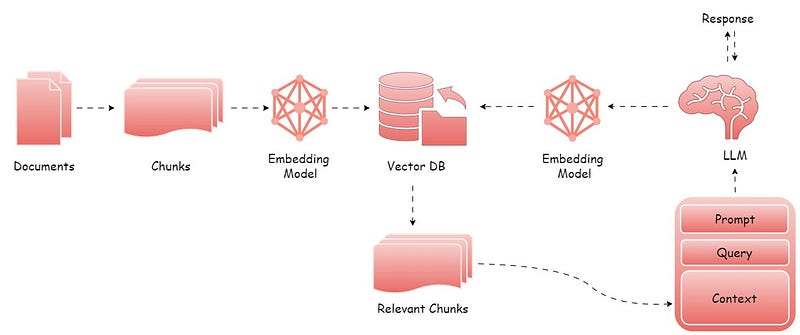

In [14]:
'''
Load pdf files
'''
loader = DirectoryLoader('data', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

'''
Split the data 
'''
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap=250,
    )
chunks= text_splitter.split_documents(documents=docs)
strings= [doc.page_content for doc in chunks] 

'''
Get embeddings
'''
embeddings = OpenAIEmbeddings() # or OpenAIEmbeddings(model='text-embedding-3-small')
vectors = embeddings.embed_documents(strings)

''' 
Create Vector DB
'''
db = Chroma.from_documents(chunks, embeddings)
retriever = db.as_retriever(search_kwargs={"k":5}) # Search in the best k retrieved documents

## Dimensionality Reduction: 2-Dimensional Transformations
In order to visualize vector embeddings in a 2-D space, such dimensionality reduction step is required.

In [17]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

'''
Transfor vectros into 2D to make a visualization of our embeddings
'''
umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors) 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.3.10-py3-none-any.whl size=38867 sha256=78a9fa8adada27cc954e7ecefd06bc28973df0576ff770f5b5210a399de669f2
  Stored in directory: /home/jovyan/.cache/pip/wheels/fa/7c/c0/f6b5434510bef2e044d9c2e81f2f204c85b1412e85a90a16aa
Successfully built umap-learn


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [18]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:04<00:00, 48.82it/s]


(-6.225180268287659,
 10.308307766914368,
 -3.3729962944984435,
 4.159898960590363)

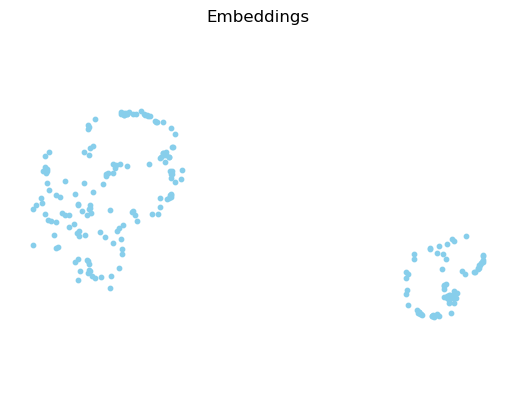

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='skyblue')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

The figure above represents the vector embeddings of the two documents used, namely `GANs.txt` and `Backpropagation.txt`. It will be shown lated the the set of points to the left represents the information about GANs, whereas those to the right represent those on Backpropagation.

In [59]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='skyblue')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=100, marker='X', color='firebrick')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='b')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

## Display Relevant Documents of a Query
The following is a demonestration of giving a query as an input, and it's location as well as the relevant documents location from the vector database will be shown.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.08it/s]


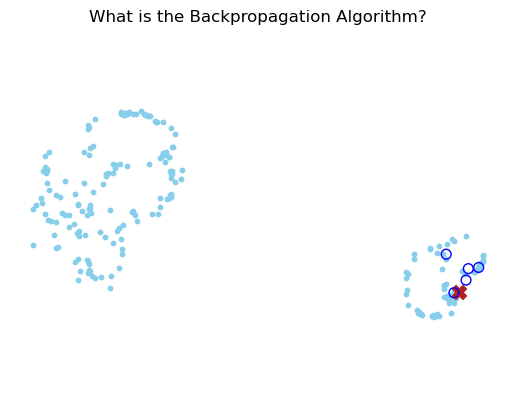

In [60]:
quiery = "What is the Backpropagation Algorithm?"
calc_global_embeddings(quiery, embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 93.13it/s]


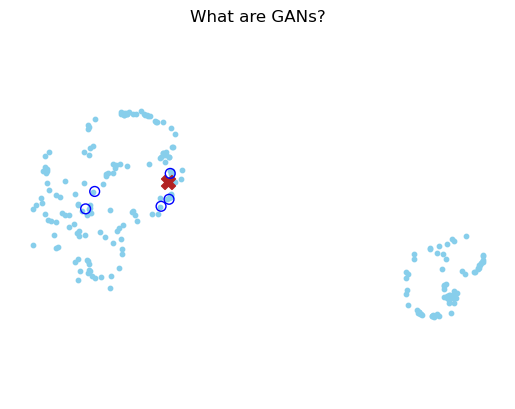

In [61]:
quiery = "What are GANs?"
calc_global_embeddings(quiery, embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

## Query Expansion
To not only consider a single relevant document (red-cross), but also other related documents (blue circles), the query needs to be processed in a way such that multiple quires are generated out of it, that are identical, but different formulation, to increase the likelyhood of getting as much relevant information as possible.

In [24]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(
        temperature=0,
        max_tokens=1000,
        model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
    )

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [30]:
# !pip install langchain-core==0.1.4

In [27]:
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

class LineList(BaseModel):
    lines: list[str] = Field(description="Lines of text")

class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> list[str]:
        lines = text.strip().split("\n")
        return lines

output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
)


In [33]:
query = "What is the Backpropagation Algorithm?"

llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT, output_parser=output_parser)
queries = llm_chain.invoke(query)

In [34]:
queries = queries.get("text")
queries

['What does the Backpropagation Algorithm entail?',
 'Explain the Backpropagation Algorithm.',
 'Can you provide information on the Backpropagation Algorithm?',
 'How does the Backpropagation Algorithm work?',
 'Tell me about the Backpropagation Algorithm.']

As you see, the original query was "What is the Backpropagation Algorithm?", the model generated 5 variations of that sentence, note that the number of synonems can be adjusted in the prompt.

## Cross Encoders
This is the core of this notebook. Just bellow it shows the retrieved documents for all the variations of the original query as shown bellow. Then, to avoid repetetions the duplicates are removed.

In [36]:
docs = [retriever.get_relevant_documents(query) for query in queries]

In [37]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

The following is then done by the cross-encoder:

- The most relevant data is obtained from the vector DB.
- The cross encoder re-orders them ascendingly or descendingly based on importance.
- Using document_transformers and LongContextReorder, the list of documents will be re-ordered again such that the important documents exist in both the beginning and end of the list, forming a U-Shap on the performance curve.

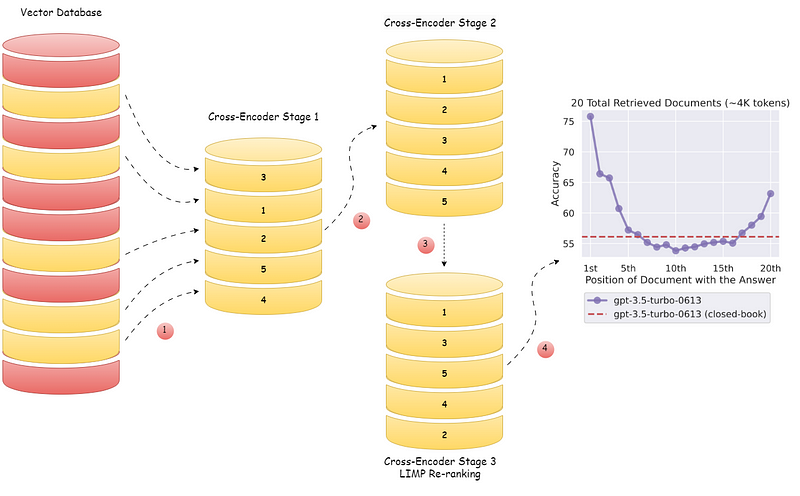

In [42]:
# !pip install sentence_transformers
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

  Using cached sentence_transformers-2.5.1-py3-none-any.whl (156 kB)
  Using cached transformers-4.39.0-py3-none-any.whl (8.8 MB)
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 865.0 kB/s eta 0:00:00m eta 0:00:010:00:06
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [43]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

scores = cross_encoder.predict(pairs)

scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)

reranked_docs = [doc for _, doc in sorted_docs][0:10]

## U-Shape Reranking
In order to get the final re-ordering, the following is done.

In [44]:
from langchain_community.document_transformers import LongContextReorder

reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)

In [45]:
reordered_docs

['To minimize this loss, backpropagation calculates the gradient of the loss function with respect to each weight and bias in the network. This involves a backward traversal from the output layer through the hidden layers to the input layer, updating weights and biases based on their contribution to the error. This is where partial derivatives come into play, guiding the adjustments to reduce error.',
 'At its core, backpropagation is all about correcting mistakes. Imagine teaching a child to ride a bike; you observe their performance and guide them on how to improve. Similarly, backpropagation observes how far a neural network’s output is from the expected result and makes adjustments accordingly. This process involves intricate mathematics and a deep understanding of how neural networks function but is pivotal for enabling machines to learn from their errors.\n\nOne of the most exciting aspects of backpropagation is its universal applicability across different neural network architec